In [1]:
# System packages
import io
from io import StringIO
import os
import sys

import numpy as np
import pandas as pd

# Read on S3
import boto.s3
import boto3

# image
import matplotlib.pyplot as plt
import cv2

In [2]:
import pyspark

In [3]:
pyspark.__version__

'3.0.1'

In [4]:
import random

In [5]:
from pyspark.sql import SparkSession
from pyspark import SQLContext

In [18]:
import findspark
findspark.init('C:/Users/etien/DataScience/code/')

Exception: Unable to find py4j, your SPARK_HOME may not be configured correctly

In [8]:
sc = pyspark.SparkContext(appName="Pi")
num_samples = 10000

def inside(p):     
  x, y = random.random(), random.random()
  return x*x + y*y < 1

count = sc.parallelize(range(0, num_samples)).filter(inside).count()

pi = 4 * count / num_samples
print(pi)

sc.stop()

3.166


In [11]:
def inside(p):     
  x, y = random.random(), random.random()
  return x*x + y*y < 1

In [2]:
# decomposition
from sklearn.decomposition import PCA
# transformer
from sklearn.preprocessing import StandardScaler

In [3]:
# timing
import time

# Connect to S3 storage bucket

In [9]:
s3 = boto3.resource('s3')

In [10]:
for bucket in s3.buckets.all():
    print(bucket.name)

oc-p8-fruits-storage


# Put files into storage bucket

In [16]:
# bulk rename to remove spaces out of folders name
# warning : do not apply until checking the parent location
def rename_folders(parent):
    for path, folders, _ in os.walk(parent):
        for i in range(len(folders)):
            new_name = folders[i].replace(' ', '_')
            os.rename(os.path.join(path, folders[i]), os.path.join(path, new_name))
            folders[i] = new_name

In [17]:
# only one time
# rename_folders('Inputs/Training')

In [ ]:
# upload S3 through awscli : aws s3 cp Inputs s3://oc-p8-fruits-storage/ --recursive

In [19]:
client_s3 = boto3.client('s3')

In [7]:
help(boto3)

Help on package boto3:

NAME
    boto3

DESCRIPTION
    # Copyright 2014 Amazon.com, Inc. or its affiliates. All Rights Reserved.
    #
    # Licensed under the Apache License, Version 2.0 (the "License"). You
    # may not use this file except in compliance with the License. A copy of
    # the License is located at
    #
    # http://aws.amazon.com/apache2.0/
    #
    # or in the "license" file accompanying this file. This file is
    # distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF
    # ANY KIND, either express or implied. See the License for the specific
    # language governing permissions and limitations under the License.

PACKAGE CONTENTS
    compat
    docs (package)
    dynamodb (package)
    ec2 (package)
    exceptions
    resources (package)
    s3 (package)
    session
    utils

CLASSES
    logging.Handler(logging.Filterer)
        NullHandler
    
    class NullHandler(logging.Handler)
     |  NullHandler(level=0)
     |  
     |  Handler instanc

# Build a DataFrame from 1-D image vectors as Row labeled

In [180]:
from PIL import Image

In [184]:
from numpy import asarray

In [ ]:
# image -> NumPy : array np.asarray() original shape (100, 100, 3)
# NumPy array -> image : Image.fromarray() ()

In [340]:
parent = 'Inputs/AppleSample'
df_collect = pd.DataFrame()

In [13]:
image_df = pyspark.read.format("image").load(parent)

AttributeError: module 'pyspark' has no attribute 'read'

In [341]:
# parse the folders and files in parent
start = time.time()
for path, folders, files in os.walk(parent):
        # check if no subfolders
        if folders==[]:
            # label
            label = os.path.basename(path)
            # image
            for f in files:
                row_sample = np.asarray(
                    Image.open(
                        os.path.join(
                            path,
                            f
                        ))).ravel()
                df_sample = pd.DataFrame(row_sample).T
                df_sample.insert(0, 'label', label)
                df_collect = df_collect.append(df_sample, ignore_index=True)
end = time.time()
print('elapsed time in s.: ', end - start)

elapsed time in s.:  95.30849099159241


In [342]:
df_collect.shape

(2134, 30001)

In [343]:
df_collect.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2134 entries, 0 to 2133
Columns: 30001 entries, label to 29999
dtypes: object(1), uint8(30000)
memory usage: 61.2 MB


In [344]:
df_collect.head(3)

,label,0,1,2,3,4,5,6,7,8,...,29990,29991,29992,29993,29994,29995,29996,29997,29998,29999
0,Apple_Braeburn,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
1,Apple_Braeburn,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
2,Apple_Braeburn,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


# Reduce

In [368]:
X = df_collect.drop(df_collect.columns[0], axis=1)

In [369]:
X.shape

(2134, 30000)

In [370]:
pca = PCA(n_components=16)

In [371]:
std = StandardScaler()

In [372]:
# standard scaler
start = time.time()
X_std = std.fit_transform(X)
end = time.time()
print('elapsed time in s.: ', end - start)

elapsed time in s.:  3.8163204193115234


In [373]:
# PCA
start = time.time()
X_pca = pca.fit_transform(X_std)
end = time.time()
print('elapsed time in s.: ', end - start)

elapsed time in s.:  4.169957399368286


In [374]:
X_pca.shape

(2134, 16)

In [375]:
df_reduced = pd.DataFrame(X_pca)

In [376]:
df_reduced.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2134 entries, 0 to 2133
Columns: 16 entries, 0 to 15
dtypes: float64(16)
memory usage: 266.9 KB


# get back to image

In [377]:
pca.explained_variance_ratio_

array([0.24310712, 0.14017661, 0.07588961, 0.05012646, 0.03912474,
       0.0299986 , 0.02573822, 0.02273373, 0.01579342, 0.01513669,
       0.01323951, 0.01201951, 0.01057783, 0.00959536, 0.00861762,
       0.00793844])

In [378]:
df_components = pd.DataFrame(pca.components_)

In [379]:
df_components.shape

(16, 30000)

In [404]:
df_components.shape[0]

16

In [381]:
pca.components_[0].size

30000

In [389]:
df_inverse = pd.DataFrame(std.inverse_transform(df_components).astype('uint8'))

In [411]:
np.arange(0, df_inverse.shape[0])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [412]:
df_inverse.iloc[[0]].values

array([[254, 254, 254, ..., 255, 255, 255]], dtype=uint8)

In [418]:
# get pca image "components"
pc_array = []
for i in np.arange(0, df_inverse.shape[0]):
    pc_array.append(df_inverse.iloc[[i]].values.reshape(shape))

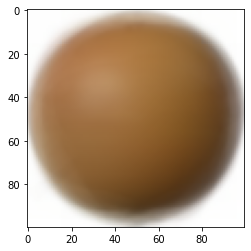

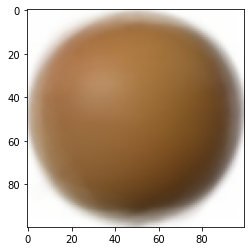

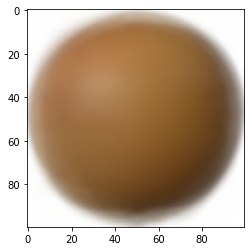

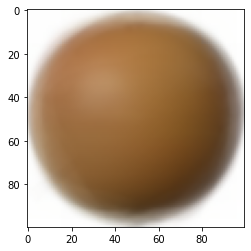

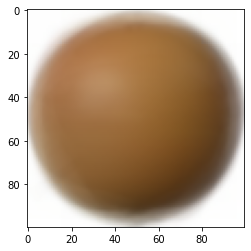

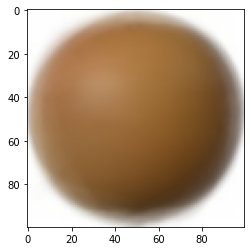

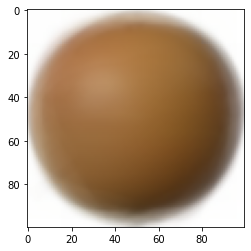

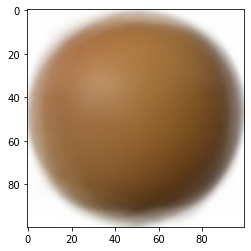

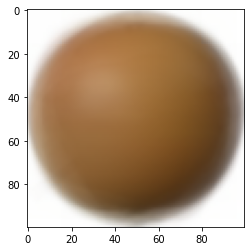

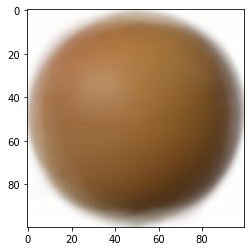

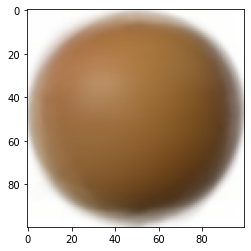

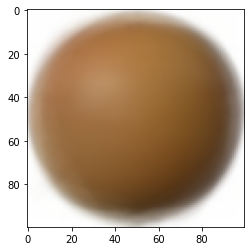

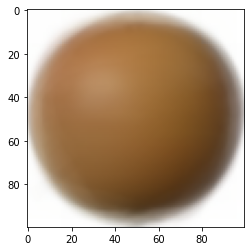

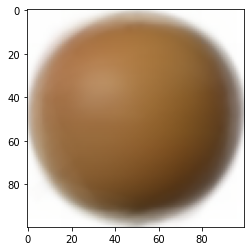

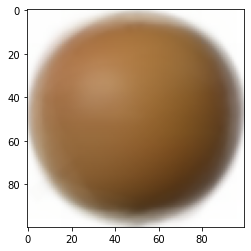

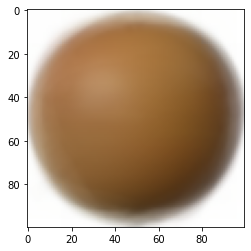

In [420]:
for i in np.arange(0, df_inverse.shape[0]):
    pc_img = Image.fromarray(pc_array[i])
    plt.imshow(pc_img)
    plt.show()

In [399]:
# once you get the original size of a np array from np.asarray()
shape

(100, 100, 3)

In [400]:
# reform an array of the original shape
pc1 = row.reshape(shape)

In [402]:
img_pc1 = Image.fromarray(pc1)

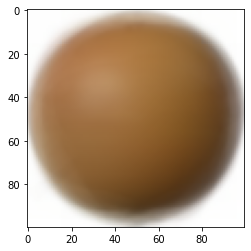

In [403]:
plt.imshow(img_pc1)